# Classification of synapses

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

scifAI: An explainable AI python framework for the analysis of multi-channel imaging flow cytometry data


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, train_validation_test_split
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [3]:
from iflai.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

data_path = "/pstore/data/DS4/White_blood_cell_dataset/"
metadata = scifAI.metadata_generator(data_path)

Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 31280/31280 [00:08<00:00, 3825.85it/s]


...metadata prepration ended.
CPU times: user 496 ms, sys: 214 ms, total: 709 ms
Wall time: 8.76 s


In [6]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)

In [7]:
metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,26659,labeled,CD15+ neutrophil
1,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,30716,labeled,CD15+ neutrophil
2,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,30519,labeled,CD14+ monocyte
3,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,822,labeled,CD15+ neutrophil
4,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,17483,labeled,CD15+ neutrophil
...,...,...,...,...,...,...,...
29989,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,25994,labeled,CD15+ neutrophil
29990,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,3211,labeled,CD8+ T
29991,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,29508,labeled,CD14+ monocyte
29992,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,23111,labeled,CD4+ T


['CD15+ neutrophil' 'CD14+ monocyte' 'eosinophil' 'CD4+ T' 'CD56+ NK'
 'NKT' 'CD8+ T' 'CD19+ B']


<AxesSubplot:>

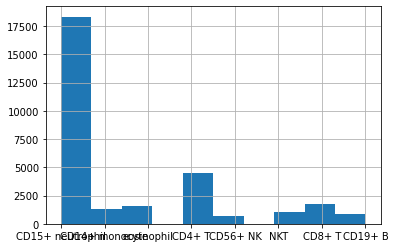

In [8]:
print(metadata.label.unique())
metadata.label.hist()

so we have 31280  files with various labels. first we need to get rid of `unknown` labels

In [9]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)

lets plot a random image per class

In [10]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w


Set all random seeds to the specific value, so the results are more reproducable

In [11]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define all necessary parameters

In [12]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [13]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 255.
reshape_size = 64
train_transform = [
        transforms.RandomResizedCrop(reshape_size, scale=(0.6, 1.0), ratio=(0.8, 1.2)),
         transforms.RandomHorizontalFlip(),
         transforms.RandomVerticalFlip(),
         AddGaussianNoise(mean=0., std=0.005),
        ]
test_transform = [ ]
num_classes = len(metadata.label.unique())

In [14]:

selected_channels = np.arange(12)
num_channels = len(selected_channels)
channels = np.asarray(["BF1", "CD15","SigL8","CD14","CD19","DF","CD3", "CD45","BF2","CD4","CD56","CD8"])
num_of_all_channels = len(channels)
all_channels = np.arange(num_of_all_channels)

In [15]:
batch_size = 128
num_workers = 4
device="cuda"

In [16]:
channel_importance = pd.read_csv("channel_importance.csv")
channel_importance

,fold,channel,PXPermute,DeepLift,LRP,GuidedGradCAM,IntegratedGradients
0,4,BF1,0.002034,1.605426e-03,-12.400846,-8.991536e-06,2.074527e-03
1,4,CD15,0.000439,6.993967e-06,-1.822934,-5.708454e-07,6.186348e-06
2,4,SigL8,0.001351,-7.963992e-05,-4.014456,5.194120e-06,-3.797350e-04
3,4,CD14,0.004518,-6.376401e-04,26.060090,8.728705e-06,-6.020912e-04
4,4,CD19,0.002529,9.043738e-05,-3.469203,-2.045696e-06,1.075690e-04
5,4,DF,0.000408,3.171338e-06,-0.689515,-2.486031e-06,2.249079e-06
6,4,CD3,0.033621,-1.425941e-04,-5.446074,-1.894273e-05,-2.290062e-04
7,4,CD45,0.001697,-2.354621e-05,0.477934,4.060209e-07,-2.032990e-05
8,4,BF2,0.001648,-1.655548e-03,19.235951,2.054818e-05,-1.797451e-03
9,4,CD4,0.053532,1.444129e-03,-16.101868,-4.654780e-05,1.718252e-03


In [17]:
from sklearn.preprocessing import MinMaxScaler
interpretation_methods = ["PXPermute", "DeepLift", "LRP", "GuidedGradCAM","IntegratedGradients"]
channel_importance.loc[:, interpretation_methods] = MinMaxScaler().fit_transform(channel_importance.loc[:, interpretation_methods])



<AxesSubplot:xlabel='variable', ylabel='value'>

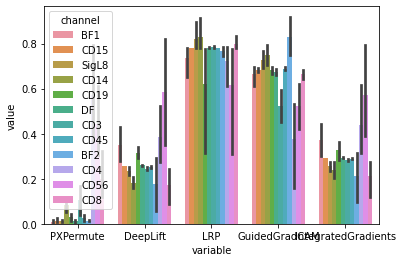

In [18]:
import seaborn as sns
sns.barplot(data = pd.melt(channel_importance, id_vars=["fold","channel"]), 
            x = "variable", 
            y = "value",
            hue = "channel")

In [19]:
channel_importance.channel.unique()

array(['BF1', 'CD15', 'SigL8', 'CD14', 'CD19', 'DF', 'CD3', 'CD45', 'BF2',
       'CD4', 'CD56', 'CD8'], dtype=object)

In [20]:
channel_map = dict()
for i, ch in enumerate(channels):
    channel_map[ch] = "Ch" + str(i)

channel_importance.channel = channel_importance.channel.replace(channel_map)

<AxesSubplot:xlabel='variable', ylabel='value'>

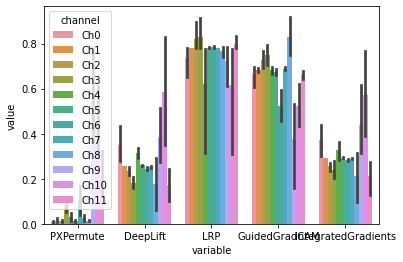

In [21]:
import seaborn as sns
sns.barplot(data = pd.melt(channel_importance, id_vars=["fold","channel"]), 
            x = "variable", 
            y = "value",
            hue = "channel")

In [22]:
def select_top_channels(channel_importance, method, num_top_channels):
    grouped_importance = channel_importance.loc[:,["channel",method]].groupby("channel").mean()
    grouped_importance = grouped_importance.sort_values(by=method, ascending = False) 
    selected_channels = grouped_importance.index[:num_top_channels]
    selected_channels = [int(ch.replace("Ch","")) for ch in selected_channels]
    return selected_channels

In [23]:
def get_statistics(dataloader, selected_channels):
    nmb_channels = len(selected_channels)

    statistics = dict()
    statistics["p01"] = torch.zeros(nmb_channels)
    statistics["p99"] = torch.zeros(nmb_channels)
    for _, data_l in enumerate(tqdm(dataloader), 0):
        image, _ = data_l
        for n in range(nmb_channels):
            statistics["p01"][n] += torch.quantile(image[:, n, :, :], 0.01)
            statistics["p99"][n] += torch.quantile(image[:, n, :, :], 0.99)

    # averaging
    for k in statistics:
        statistics[k] = statistics[k].div_(len(dataloader))

    print('statistics used: %s' % (str(statistics)))

    return statistics

In [24]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [ ]:

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch.nn as nn
from scifAI.dl.models import PretrainedModel
import torch.nn.functional as F

num_top_channels = 6
skf = StratifiedKFold(n_splits=5, random_state=seed_value, shuffle=True)


results_with_best_channels = pd.DataFrame(columns = ["method",
                                                     "f1_micro",
                                                     "f1_macro",
                                                     "accuracy"])

for met in interpretation_methods:
    selected_channels = select_top_channels(channel_importance, met , num_top_channels)
    channels = np.asarray([ "Ch" + str(i) for i in selected_channels])
    
    print(met, selected_channels)
    num_of_all_channels = len(channels)
    all_channels = np.arange(num_of_all_channels)
    for train_index, test_index in skf.split(metadata.index.tolist(), metadata["label"]):
        train_index, validation_index, _, _ = train_test_split(train_index, 
                                                    metadata.loc[train_index,"label"].index.tolist(), 
                                                    stratify = metadata.loc[train_index,"label"].tolist(),
                                                    test_size=0.2, 
                                                    random_state=seed_value)
        label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), 
                     np.arange(len(set(metadata.loc[train_index, "label"])))))

        set_of_interesting_classes = metadata.label.unique().tolist()

        num_classes = len(metadata.label.unique())
        
        train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose([ ] ))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        statistics = get_statistics(train_loader, selected_channels=selected_channels)
        
        stats = dict()
        stats["lower_bound"] = torch.tensor([statistics['p01'][0], 
                                             statistics['p01'][1], 
                                             statistics['p01'][2], 
                                             statistics['p01'][3], 
                                             statistics['p01'][4], 
                                             statistics['p01'][5]])

        stats["upper_bound"] = torch.tensor([statistics['p99'][0], 
                                             statistics['p99'][1], 
                                             statistics['p99'][2], 
                                             statistics['p99'][3], 
                                             statistics['p99'][4], 
                                             statistics['p99'][5]])

        train_transform = [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                AddGaussianNoise(mean=0., std=0.01),
        ]

        validation_transform =  [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
        ]

        test_transform =  [ 
                MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                        max_in =  stats["upper_bound"] , 
                                        min_out =  0. , 
                                        max_out =  1.),
        ]
        
        train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

        validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                              label_map=label_map,
                                              selected_channels=selected_channels,
                                              scaling_factor=scaling_factor,
                                              reshape_size=reshape_size,
                                              transform=transforms.Compose(validation_transform))
        
        test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                        label_map=label_map,
                                        selected_channels=selected_channels,
                                        scaling_factor=scaling_factor,
                                        reshape_size=reshape_size,
                                        transform=
                                        transforms.Compose(test_transform))
        
        

        resnet18_modified = PretrainedModel(num_channels = len(selected_channels),
                                             num_classes = len(set_of_interesting_classes), 
                                             pretrained = True)
        
        lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.5, patience=5)

        epoch_scoring_f1_micro = EpochScoring("f1_micro", 
                                     name =  "valid_f1_micro", 
                                     on_train = False,
                                     lower_is_better = False)

        epoch_scoring_f1_macro = EpochScoring("f1_macro", 
                                     name =  "valid_f1_macro", 
                                     on_train = False,
                                     lower_is_better = False)

        early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                                       patience=50, 
                                       threshold=0.0001, 
                                       threshold_mode='rel', 
                                       lower_is_better=False)

        checkpoint = Checkpoint(f_params='white_blood_cells_DL_method_comparison.pth',
                                monitor='valid_f1_macro_best', load_best=True)
        
        net = NeuralNetClassifier(    
            resnet18_modified, 
            criterion=nn.CrossEntropyLoss,
            lr=0.001,
            batch_size=batch_size,
            max_epochs=1000,
            optimizer=optim.Adam,
            iterator_train__shuffle=True,
            iterator_train__num_workers=num_workers,
            iterator_valid__shuffle=False,
            iterator_valid__num_workers=2,
            callbacks=[lr_scheduler, epoch_scoring_f1_micro, 
                       epoch_scoring_f1_macro, 
                       early_stopping, checkpoint],
            train_split=predefined_split(validation_dataset),
            device="cuda",
            warm_start=True)
        net = net.fit(train_dataset, y = None)
        net.module.load_state_dict(torch.load('white_blood_cells_DL_method_comparison.pth')) 
        
        inv_label_map = {v: k for k, v in label_map.items()}

        preds = net.predict(test_dataset)
        preds =  [inv_label_map[int(t)] for t in preds]
        
        results_with_best_channels = results_with_best_channels.append({
            "method":met,
            "f1_micro":f1_score(test_dataset.metadata.label, preds, average="micro"),
            "f1_macro":f1_score(test_dataset.metadata.label, preds, average="macro"),
            "accuracy":accuracy_score(test_dataset.metadata.label, preds),
        },ignore_index = True)
        net = None
        resnet18_modified = None
        torch.cuda.empty_cache()
        print("---------------------------"*3)

PXPermute [9, 10, 11, 6, 3, 4]


100%|██████████| 150/150 [00:52<00:00,  2.85it/s]


statistics used: {'p01': tensor([0.1723, 0.0532, 0.1198, 0.1364, 0.0667, 0.1020]), 'p99': tensor([0.4456, 0.1317, 0.2303, 1.1397, 0.1559, 0.1449])}


In [ ]:
results_with_best_channels

now we calculate the statistics of every channel to later use for nomalizing the dataset

In [ ]:
import seaborn as sns
sns.barplot(data = results_with_best_channels, 
            x = "method", 
            y = "f1_macro",
           palette = ["gray"])

In [ ]:
results_with_best_channels.to_csv("results_with_best_channels.csv", index = True)

<AxesSubplot:xlabel='method', ylabel='f1_macro'>

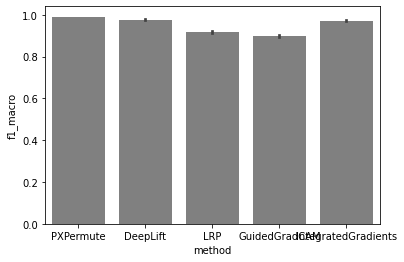

In [29]:
import seaborn as sns
sns.barplot(data = results_with_best_channels, 
            x = "method", 
            y = "f1_macro",
           palette = ["gray"])